Epoch 1, Loss: 1.4758, Train Acc: 0.3632
Epoch 2, Loss: 1.0986, Train Acc: 0.4955
Epoch 3, Loss: 0.7214, Train Acc: 0.6996
Epoch 4, Loss: 0.5881, Train Acc: 0.7848
Epoch 5, Loss: 0.4496, Train Acc: 0.8184
Epoch 6, Loss: 0.3876, Train Acc: 0.8475
Epoch 7, Loss: 0.2866, Train Acc: 0.8834
Epoch 8, Loss: 0.2368, Train Acc: 0.9193
Epoch 9, Loss: 0.1900, Train Acc: 0.9148
Epoch 10, Loss: 0.1141, Train Acc: 0.9619
Epoch 11, Loss: 0.0690, Train Acc: 0.9753
Epoch 12, Loss: 0.0405, Train Acc: 0.9910
Epoch 13, Loss: 0.0261, Train Acc: 0.9888
Epoch 14, Loss: 0.0416, Train Acc: 0.9821
Epoch 15, Loss: 0.0407, Train Acc: 0.9798
Epoch 16, Loss: 0.0498, Train Acc: 0.9843
Epoch 17, Loss: 0.0275, Train Acc: 0.9933
Epoch 18, Loss: 0.0088, Train Acc: 0.9978
Epoch 19, Loss: 0.0097, Train Acc: 0.9955
Epoch 20, Loss: 0.0093, Train Acc: 0.9955
Epoch 21, Loss: 0.0231, Train Acc: 0.9888
Epoch 22, Loss: 0.0291, Train Acc: 0.9910
Epoch 23, Loss: 0.0308, Train Acc: 0.9865
Epoch 24, Loss: 0.0331, Train Acc: 0.9865
E

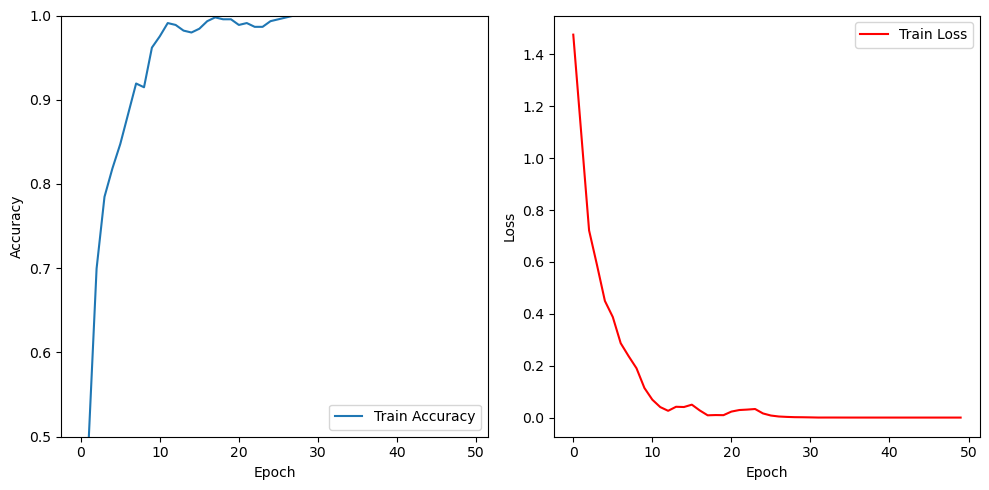

In [19]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

class KazNU_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []  
        self.labels = []  
        self.classes = []  
        self._load_data()

    def _load_data(self):
        for class_name in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                self.classes.append(class_name) 
                for image_name in os.listdir(class_dir):
                    if image_name.endswith('.jpg'):
                        self.images.append(os.path.join(class_dir, image_name))
                        self.labels.append(class_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.classes.index(label)
        
        return image, label


transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 64)  
        self.fc2 = nn.Linear(64, num_classes)  

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 64 * 4 * 4)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNN(num_classes=len(train_dataset.classes))  

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


epochs = 50
train_acc = []
val_acc = []
train_loss = []  

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Әрқайсысын жеке тасымалдау
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc.append(correct / total)
    train_loss.append(running_loss / len(train_loader))  
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {correct/total:.4f}')


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f'Test Accuracy: {test_acc:.4f}')


plt.figure(figsize=(10,5))


plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(train_loss, 'r', label='Train Loss')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
from torchsummary import summary
model = CNN(num_classes=len(train_dataset.classes)).to(device)

summary(model, input_size=(3, 32, 32))


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
from PIL import Image
import matplotlib.pyplot as plt

# Кастом датасет
class KazNU_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = []
        self._load_data()

    def _load_data(self):
        for class_name in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                self.classes.append(class_name)
                for image_name in os.listdir(class_dir):
                    if image_name.endswith('.jpg'):
                        self.images.append(os.path.join(class_dir, image_name))
                        self.labels.append(class_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.classes.index(label)
        return image, label

# Модель салмақтарын алу және трансформация
weights = ResNet50_Weights.DEFAULT
transform = weights.transforms()

# Датасеттер мен DataLoader-лар
train_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = KazNU_Dataset(root_dir='/Users/zumagalievamaral/Desktop/kaznu_resized', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ ResNet50 моделін жүктеу және адаптация
resnet = models.resnet50(weights=weights)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  # Соңғы fully connected қабатты ауыстыру

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

# ✅ Loss және Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)

# ✅ Жаттығу
epochs = 10
train_acc = []
val_acc = []
train_loss = []

for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = correct / total
    loss_avg = running_loss / len(train_loader)

    train_acc.append(acc)
    train_loss.append(loss_avg)

    print(f"Epoch {epoch+1}, Loss: {loss_avg:.4f}, Train Acc: {acc:.4f}")

# ✅ Тестілеу
resnet.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

# ✅ Графиктер
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(train_loss, 'r', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/zumagalievamaral/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:04<00:00, 24.9MB/s]


Epoch 1, Loss: 1.3426, Train Acc: 0.6726
Epoch 2, Loss: 0.5863, Train Acc: 0.9888
Epoch 3, Loss: 0.1758, Train Acc: 0.9978
